In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [29]:
#generate data
train_n = 100
test_n = 10000
d = 200
X_train = np.random.normal(0,1, size=(train_n,d))
a_true = np.random.normal(0,1, size=(d,1))
y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
X_test = np.random.normal(0,1, size=(test_n,d))
y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))
def GetSMatrix(X):
    S = np.zeros((len(X[0]),len(X[0])))
    mean = np.mean(X, axis = 0).reshape(-1,1)
    for x in X:
        xx = x.reshape(-1,1)
        S += (xx - mean) @ (xx - mean).T
    return S

def GetMainVector(X, dimension):
    S = GetSMatrix(X)
    eigvalue, eigvector = np.linalg.eigh(S)
    #kmax_eigvalue = eigvalue.argsort()[-dimension:]
    kmax_eigvalue_index = np.argpartition(eigvalue, -dimension)[-dimension:]
    W = eigvector[:,kmax_eigvalue_index]
    return W

In [3]:
def getGradient(X, y, a, index, lambda_value = 0):
    #gradient below is for index -> a_t
    #gradient = 2 * (X@a  - y).T @ (X[:,index])
    #now change into index -> x_i
    gradient = (2 * (X[index]@a-y[index]) * X[index]).reshape(-1,1) + (2 * lambda_value * a).reshape(-1,1)
    return gradient.reshape((-1,1))
#using another metric, y2 is the real ture output
def NormMSELoss(y1, y2):
    return np.sqrt(np.sum((y1 - y2)**2))/np.sqrt(np.sum(y2**2))
def SGDTrain(X, y, step_size, iters, metric, batch_size=1, evaluate = False, lambda_value = 0, random_radius = 0):
    a = np.random.uniform(0,random_radius, size = (len(X[0]),1))
    obj_value = np.zeros(iters+1)
    test_error = np.zeros(iters//100 + 1)
    obj_value[0] = metric(X @ a, y)
    if evaluate:
        global X_test, y_test
        test_error[0] = metric(X_test @ a, y_test)
    for i in range(iters):
        gd = np.zeros((len(X[0]),1))
        indexs = np.array(range(len(X)))
        np.random.shuffle(indexs)
        for index_i in range(batch_size):
            index = indexs[index_i]
            gd += getGradient(X, y, a, index, lambda_value).astype(np.float64)
        #update a with gradient
        a = a - step_size * gd
        obj_value[i+1] = metric(X @ a, y)
        if evaluate and (i+1) % 100 == 0:
            test_error[(i+1)//100] = metric(X_test @ a, y_test)
    if evaluate:
        return obj_value, test_error
    else:
        return obj_value

In [25]:
trial_times = 100
training_error_base1 = 0
test_error_base1 = 0

for _ in range(trial_times):
    training_error_base1 += NormMSELoss(X_train @ a_true, y_train)
    test_error_base1 += NormMSELoss(X_test @ a_true, y_test)

training_error_base1 /= trial_times
test_error_base1 /= trial_times
print('training error = ', training_error_base1)
print('test error = ', test_error_base1)

training error =  0.038201464169702486
test error =  0.03399400071330658


lambda value: 5.000000; dimension: 10; final testing error: 0.988451; final training error: 0.919809  
lambda value: 0.500000; dimension: 10; final testing error: 0.985965; final training error: 0.896647  
lambda value: 0.050000; dimension: 10; final testing error: 0.985917; final training error: 0.893977  
lambda value: 0.005000; dimension: 10; final testing error: 0.986033; final training error: 0.896996  
lambda value: 0.000000; dimension: 10; final testing error: 0.986265; final training error: 0.897142  
lambda value: 5.000000; dimension: 50; final testing error: 0.951139; final training error: 0.764880  
lambda value: 0.500000; dimension: 50; final testing error: 0.921422; final training error: 0.609369  
lambda value: 0.050000; dimension: 50; final testing error: 0.920089; final training error: 0.600556  
lambda value: 0.005000; dimension: 50; final testing error: 0.920329; final training error: 0.602818  
lambda value: 0.000000; dimension: 50; final testing error: 0.920578; fin

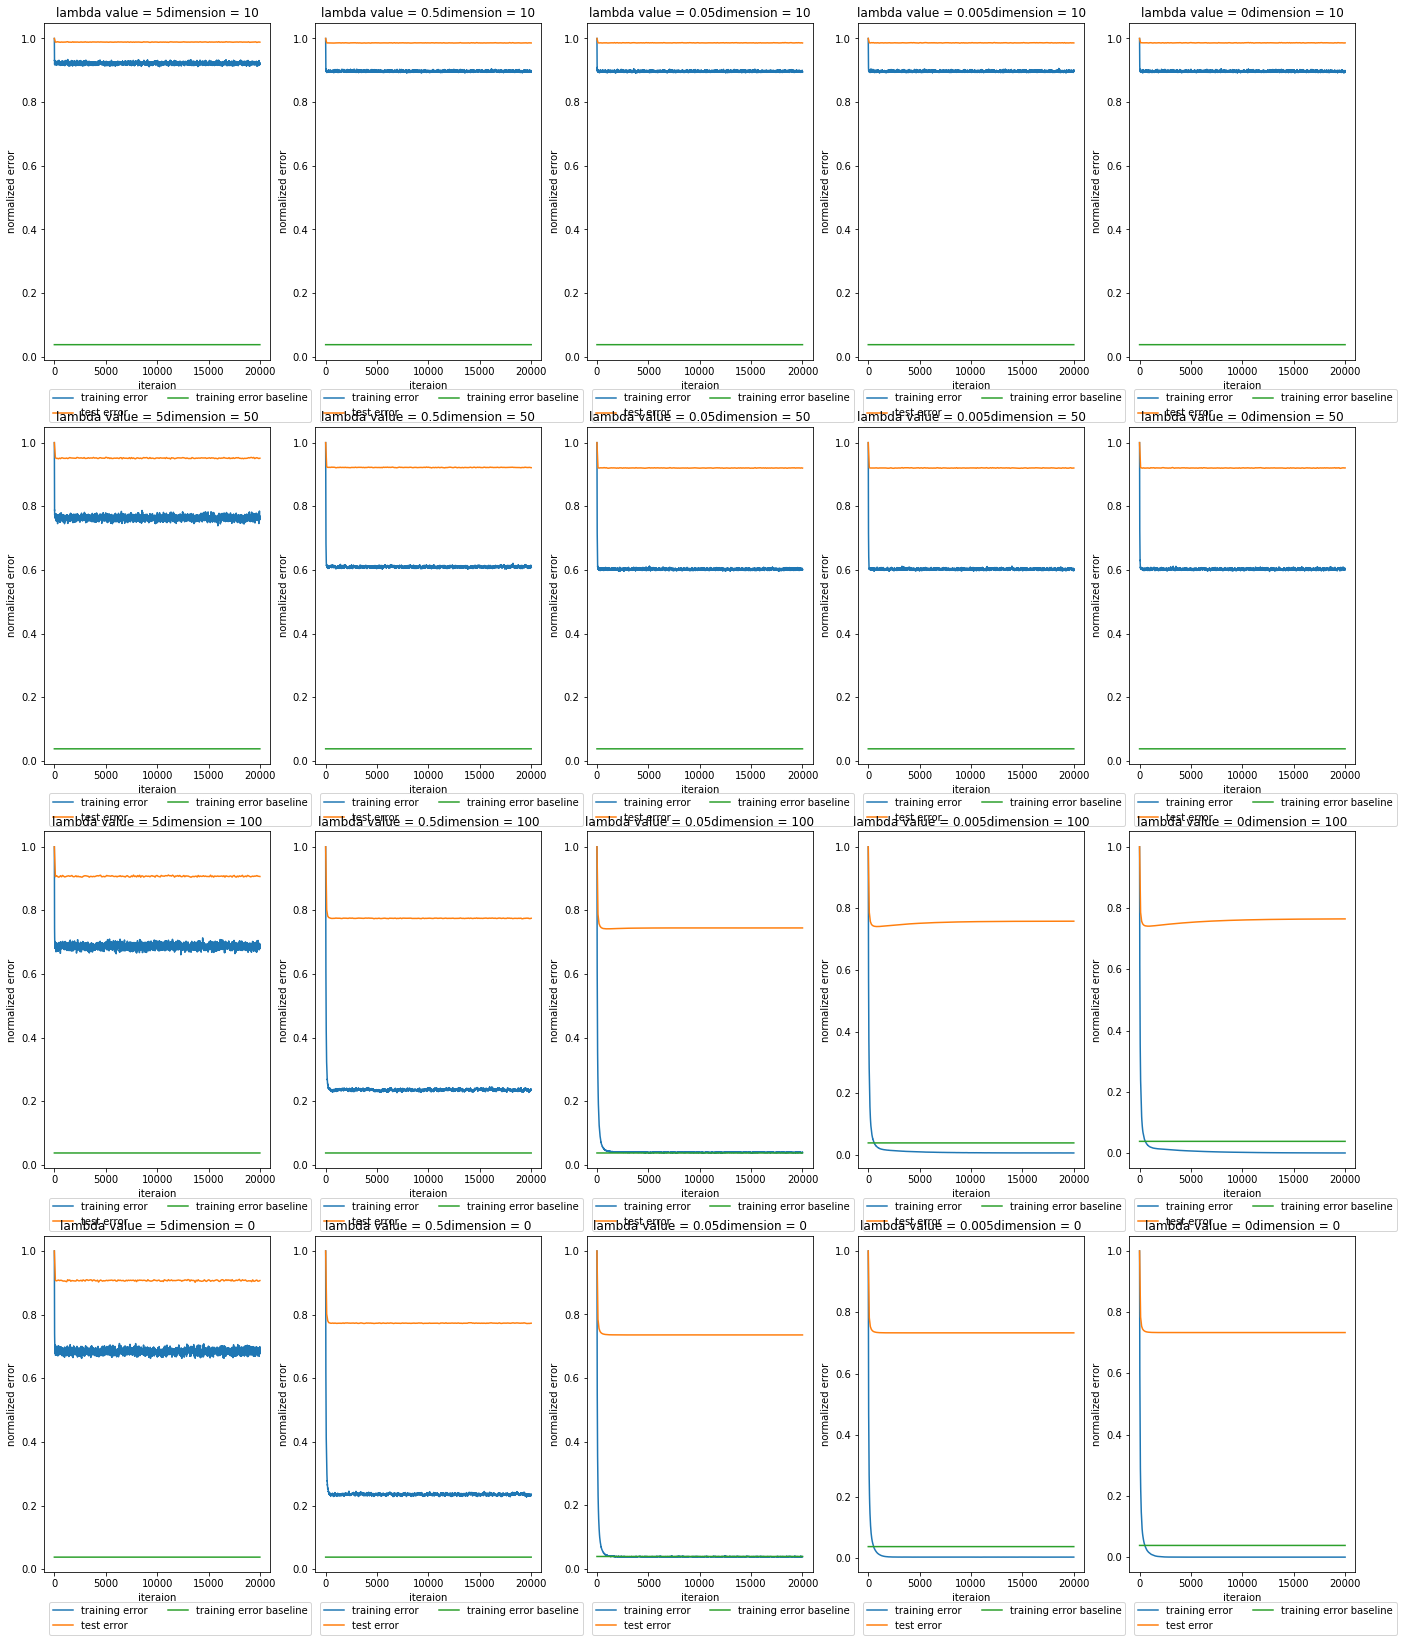

average running time = 6.092765116460692 s


In [30]:
train_iter = 20000
trial_times = 10
total_running_time = 0

dimension_list = [10, 50, 100, 0]
lambda_value_list = [5, 0.5, 0.05, 0.005, 0]
plt.figure(figsize=(5*len(dimension_list)+3.5,(5*len(lambda_value_list)+3.5)))

x_train_tmp = X_train[:]
x_test_tmp = X_test[:]
for j in range(len(dimension_list)):
    dimension = dimension_list[j]
    if dimension != 0:
        M = GetMainVector(X_train, dimension)
        X_train = X_train @ M
        X_test = X_test @ M
    for i in range(len(lambda_value_list)):
        #for 10 times
        running_time = 0
        total_training_errors = np.zeros(train_iter+1)
        total_test_errors = np.zeros(train_iter//100+1)

        for _ in range(trial_times):
            running_start = time.clock()
            training_errors, test_errors = SGDTrain(X_train, y_train, 0.0005, train_iter,\
                                                     NormMSELoss, batch_size=10, evaluate = True, lambda_value = lambda_value_list[i])
            running_time += time.clock() - running_start
            total_training_errors += training_errors
            total_test_errors += test_errors

        total_running_time += running_time / trial_times

        x_index1 = list(range(0,train_iter+1,1))
        x_index2 = list(range(0,train_iter+1,100))

        plt.subplot(4, 5,j*5+i+1)
        plt.title('lambda value = ' + str(lambda_value_list[i]) + 'dimension = ' + str(dimension_list[j]))
        plt.xlabel('iteraion')
        plt.ylabel('normalized error')
        plt.plot(x_index1, total_training_errors/trial_times)
        plt.plot(x_index2, total_test_errors/trial_times)
        print("lambda value: %lf; dimension: %d; final testing error: %lf; final training error: %lf  " % (lambda_value_list[i], dimension_list[j], total_test_errors[-1]/trial_times, total_training_errors[-1]/trial_times))
        #draw base line
        global training_error_base, test_error_base

        plt.plot(x_index1, training_error_base1 * np.ones(len(x_index1)))

        plt.legend(['training error', 'test error', 'training error baseline'],\
                  bbox_to_anchor = (0,-0.2), loc = 3, ncol = 2)

    X_train = x_train_tmp
    X_test = x_test_tmp
plt.show()
print('average running time =', total_running_time / len(dimension_list) / len(lambda_value_list), 's')

<font color="blue"> 
We attempt to improve generalization ability by using PCA to reduce dimension of X. From the experiment before, we fix batch size as 10 and learning rate at 0.0005. Testing the parameters $\lambda \in {0, 0.005, 0.05, 0.5, 5}$ and $dimension after reduce \in {10, 50, 100, 0}$, 0 means not to reduce the dimension. 
<br>    
From the output of testing above, we can see that when we reduce the dimension to 100, the testing error is similar to the one without dimension reduction. When the training error less than baseline, there is overfitting absoulutely. For these reasons, we choose reduced dimension as 100 and lambda value as 0.05, which has the lowest but higher traning error than baseline error.
</font>